### Telco Customer Churn Classification Project - rough draft

In [1]:
# bring in my imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from scipy import stats
from pydataset import data

from env import host, user, password


import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare

# Plan -> Acquire -> Prepare -> Explore -> Model & Evaluate -> Deliver

## Acquire my data

In [2]:
# now we've done everything manually, let's combine and create functions
# create helper function
def get_connection(db_name):
    '''
    This function uses my info from my env file to
    create a connection url to access the sql database.
    '''
    from env import host, user, password
    return f'mysql+pymysql://{user}:{password}@{host}/{db_name}'

In [3]:
# create my function for my sql query
def get_new_telco_churn_data():
    '''
    This function reads in the telco churn data from the sql database
    and returns a pandas DataFrame with all columns.
    '''
    sql_query = '''
    SELECT *
    FROM payment_types
    JOIN customers ON payment_types.payment_type_id = customers.payment_type_id
    JOIN internet_service_types ON internet_service_types.internet_service_type_id = customers.internet_service_type_id
    JOIN contract_types ON contract_types.contract_type_id = customers.contract_type_id;
    '''
    return pd.read_sql(sql_query, get_connection('telco_churn'))

In [4]:
df = get_new_telco_churn_data()

In [5]:
df.sample(5)

,payment_type_id,payment_type,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,...,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,internet_service_type_id,internet_service_type,contract_type_id,contract_type
304,1,Electronic check,5546-BYZSM,Female,0,No,No,41,Yes,No,...,1,No,1,20.45,775.6,No,3,None,1,Month-to-month
4559,3,Bank transfer (automatic),5732-IKGQH,Male,1,Yes,No,52,Yes,No,...,2,Yes,3,104.45,5481.25,No,2,Fiber optic,2,One year
1731,1,Electronic check,5520-FVEWJ,Female,0,Yes,Yes,12,Yes,Yes,...,1,Yes,1,84.50,916.9,Yes,2,Fiber optic,1,Month-to-month
2894,4,Credit card (automatic),2108-GLPQB,Male,0,Yes,No,25,Yes,Yes,...,1,No,4,55.55,1405.3,No,1,DSL,1,Month-to-month
2828,3,Bank transfer (automatic),1564-HJUVY,Male,0,No,No,4,Yes,No,...,1,Yes,3,63.75,226.2,No,1,DSL,1,Month-to-month


In [6]:
df.shape

(7043, 27)

### New Functions

In [22]:
df = acquire.get_new_telco_churn_data()
churned_df = df[df['churn']=='Yes']

In [23]:
df.sample(5).T

,6474,2851,3090,6336,3501
payment_type_id,3,1,1,3,2
payment_type,Bank transfer (automatic),Electronic check,Electronic check,Bank transfer (automatic),Mailed check
customer_id,0885-HMGPY,1750-CSKKM,3689-MOZGR,8207-DMRVL,6898-MDLZW
gender,Male,Male,Female,Male,Male
senior_citizen,0,0,0,0,0
partner,No,No,No,Yes,No
dependents,No,Yes,No,Yes,No
tenure,62,9,29,72,12
phone_service,Yes,Yes,No,Yes,Yes
multiple_lines,Yes,No,No phone service,Yes,No


In [24]:
churned_df.sample().T

,1499
payment_type_id,1
payment_type,Electronic check
customer_id,4548-SDBKE
gender,Female
senior_citizen,0
partner,No
dependents,No
tenure,5
phone_service,Yes
multiple_lines,Yes


In [26]:
# value counts on my churned data frame

columns = ['payment_type', 'gender', 'senior_citizen', 'partner', 'dependents', 'phone_service', 'multiple_lines', 
           'online_security', 'online_backup', 'device_protection', 'tech_support',
          'streaming_tv', 'streaming_movies', 'paperless_billing',
          'monthly_charges', 'total_charges', 'churn', 'internet_service_type', 'contract_type']

for col in columns:
    print(col)
    print(churned_df[col].value_counts())
    print('-------------')

payment_type
Electronic check             1071
Mailed check                  308
Bank transfer (automatic)     258
Credit card (automatic)       232
Name: payment_type, dtype: int64
-------------
gender
Female    939
Male      930
Name: gender, dtype: int64
-------------
senior_citizen
0    1393
1     476
Name: senior_citizen, dtype: int64
-------------
partner
No     1200
Yes     669
Name: partner, dtype: int64
-------------
dependents
No     1543
Yes     326
Name: dependents, dtype: int64
-------------
phone_service
Yes    1699
No      170
Name: phone_service, dtype: int64
-------------
multiple_lines
Yes                 850
No                  849
No phone service    170
Name: multiple_lines, dtype: int64
-------------
online_security
No                     1461
Yes                     295
No internet service     113
Name: online_security, dtype: int64
-------------
online_backup
No                     1233
Yes                     523
No internet service     113
Name: online_backup,

### What are my takeaways?
- Right off the bat I can see which columns have an obvious association to churn:
 - contract_type/contract_type_id
 - internet_service_type/internet_service_type_id
 - paperless billing
 - tech_support
 - device_protection
 - online_backup
 - online security
 - phone_service
 - dependents
 - partner
 - senior_citizen
 - payment_type/paymnent_type_id
 
----------------
 
- Things to investigate further:
 - Is there an association with total charges?
 - Is there an association with monthly charges?
 - Is there an association with tenure?
 
----------------
 
- We don't care too much about:
 - streaming_movies
 - streaming_tv
 - multiple_lines
 - gender

In [27]:
# make a df just for churned customers so we can hone in on a drive
churned_df = df[df['churn']=='Yes']

## Combine everything into functions

In [ ]:
def prep_telco_data(df):
    '''
    This function prepares and cleans the telco dataframe imported from sql.
    '''
#     df = acquire.get_new_telco_churn_data()

    # get rid of duplicate columns from the sql join
    df = df.loc[:, ~df.columns.duplicated()]

    # this is to adress the blank in total_charges. Here we replace the blank with a nan, and then drop our nulls
    df = df.replace(' ', np.nan)
    df.dropna(inplace=True)
    # change our total_charges from a string to a float
    df.total_charges = df.total_charges.astype('float')
    
    # drop the columns that do not appear to have any association to churn
    df = df.drop(columns=['streaming_movies', 'streaming_tv', 'multiple_lines', 'gender',
                         'contract_type_id', 'internet_service_type_id', 'payment_type_id'])
    
    # rename my tenure column
    df = df.rename(columns={'tenure': 'tenure_in_months'})

    # this change all of my yes and no columns to binary columns
    columns = ['partner', 'dependents', 'phone_service', 'online_security', 'online_backup', 
               'device_protection', 'tech_support', 'paperless_billing', 'churn']

    for cols in columns:
        df[cols] = np.where(df[cols] == 'Yes', 1, 0)

    return df



def create_dummies(df):
    '''
    This function is used to create dummy columns for my non binary columns
    '''
    
    # create dummies for payment_type, internet_service_type, and contract_type
    payment_dummies = pd.get_dummies(df.payment_type, drop_first=True)
    internet_dummies = pd.get_dummies(df.internet_service_type, drop_first=False)
    contract_dummies = pd.get_dummies(df.contract_type, drop_first=True)
    
    # now we concatenate our dummy dataframes with the original
    df = pd.concat([df, payment_dummies, internet_dummies, contract_dummies], axis=1)
    
    # now I am dropping all my original string columns that I made dummies with and dropping 
    #the type_id columns since they are duplicates of the string column
    df = df.drop(columns=['None', 'payment_type', 'contract_type', 'internet_service_type'])
    
    return df


def telco_split(df):
    '''
    This function takes in a dataframe and splits it into train, test, and validate dataframes for my model
    '''

    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123)
    return train, validate, test
    

In [28]:
df = prepare.prep_telco_data(df)

In [29]:
df.sample().T

,939
payment_type_id,1
payment_type,Electronic check
customer_id,2037-SGXHH
senior_citizen,0
partner,1
dependents,1
tenure_in_months,38
phone_service,1
online_security,0
online_backup,1


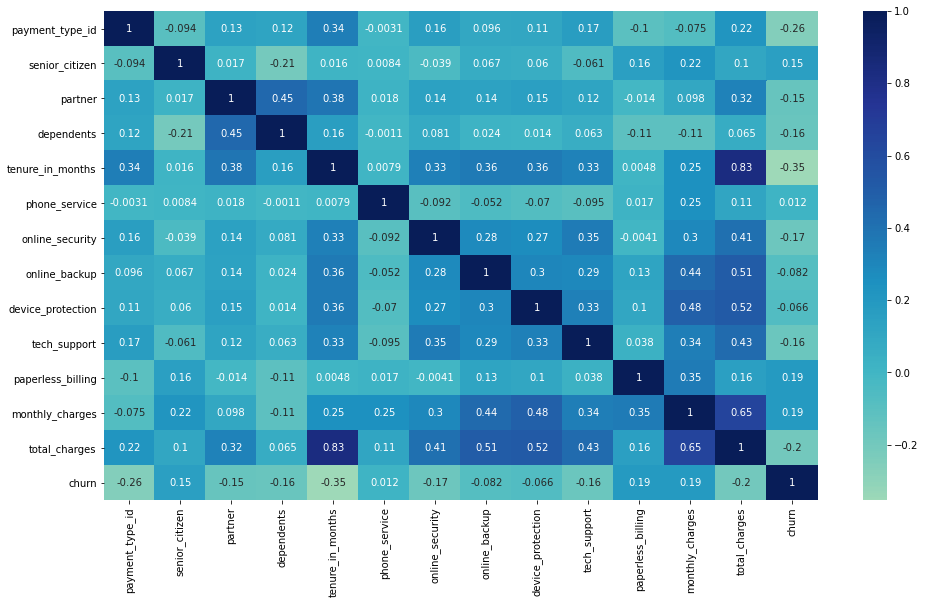

In [30]:
plt.figure(figsize=(16, 9))
sns.heatmap(((df.corr())), cmap='YlGnBu', center=0, annot=True)

plt.title('')
plt.show()

In [31]:
correl = df.corr()
correl.T

,payment_type_id,senior_citizen,partner,dependents,tenure_in_months,phone_service,online_security,online_backup,device_protection,tech_support,paperless_billing,monthly_charges,total_charges,churn
payment_type_id,1.000000,-0.093712,0.133280,0.124002,0.340939,-0.003106,0.162848,0.096246,0.110953,0.167189,-0.101790,-0.074640,0.222694,-0.262918
senior_citizen,-0.093712,1.000000,0.016957,-0.210550,0.015683,0.008392,-0.038576,0.066663,0.059514,-0.060577,0.156258,0.219874,0.102411,0.150541
partner,0.133280,0.016957,1.000000,0.452269,0.381912,0.018397,0.143346,0.141849,0.153556,0.120206,-0.013957,0.097825,0.319072,-0.149982
dependents,0.124002,-0.210550,0.452269,1.000000,0.163386,-0.001078,0.080786,0.023639,0.013900,0.063053,-0.110131,-0.112343,0.064653,-0.163128
tenure_in_months,0.340939,0.015683,0.381912,0.163386,1.000000,0.007877,0.328297,0.361138,0.361520,0.325288,0.004823,0.246862,0.825880,-0.354049
phone_service,-0.003106,0.008392,0.018397,-0.001078,0.007877,1.000000,-0.091676,-0.052133,-0.070076,-0.095138,0.016696,0.248033,0.113008,0.011691
online_security,0.162848,-0.038576,0.143346,0.080786,0.328297,-0.091676,1.000000,0.283285,0.274875,0.354458,-0.004051,0.296447,0.412619,-0.171270
online_backup,0.096246,0.066663,0.141849,0.023639,0.361138,-0.052133,0.283285,1.000000,0.303058,0.293705,0.127056,0.441529,0.510100,-0.082307
device_protection,0.110953,0.059514,0.153556,0.013900,0.361520,-0.070076,0.274875,0.303058,1.000000,0.332850,0.104079,0.482607,0.522881,-0.066193
tech_support,0.167189,-0.060577,0.120206,0.063053,0.325288,-0.095138,0.354458,0.293705,0.332850,1.000000,0.037536,0.338301,0.432868,-0.164716


Text(0.5, 1.0, 'Feautures  Correlating with Churn')

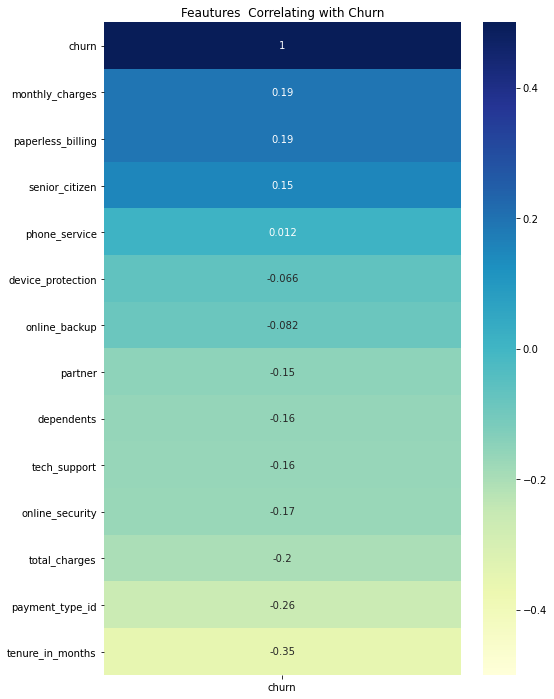

In [34]:
plt.figure(figsize=(8,12))
churn_heatmap = sns.heatmap(df.corr()[['churn']].sort_values(by='churn', ascending=False), cmap='YlGnBu', vmin=-.5, vmax=.5, annot=True)
churn_heatmap.set_title('Feautures  Correlating with Churn')

In [35]:
churned_df = df[df['churn']==1]
churned_df.sample(3).T

,3594,3264,3573
payment_type_id,1,4,2
payment_type,Electronic check,Credit card (automatic),Mailed check
customer_id,7675-OZCZG,4959-JOSRX,7551-DACSP
senior_citizen,1,0,0
partner,0,1,1
dependents,0,0,1
tenure_in_months,3,2,6
phone_service,1,1,1
online_security,0,0,0
online_backup,0,0,1


# EXPLORE

In [36]:
#  Is there an association with monthly charges?
df.monthly_charges.mean(), churned_df.monthly_charges.mean()

(64.79820819112616, 74.44133226324224)

Text(0, 0.5, 'amount of customers')

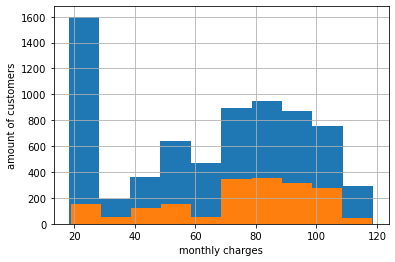

In [37]:
# churned customers pay more monthly charges than overall customers
df.monthly_charges.hist()
churned_df.monthly_charges.hist()
plt.xlabel('monthly charges')
plt.ylabel('amount of customers')

In [38]:
df.total_charges.mean(), churned_df.total_charges.mean()

(2283.300440841863, 1531.7960941680042)

Text(0, 0.5, 'amount of customers')

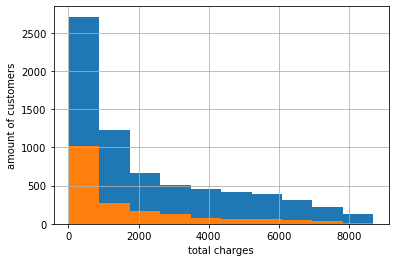

In [39]:
# comparison of total charges
df.total_charges.hist()
churned_df.total_charges.hist()
plt.xlabel('total charges')
plt.ylabel('amount of customers')

Text(0, 0.5, 'amount of customers')

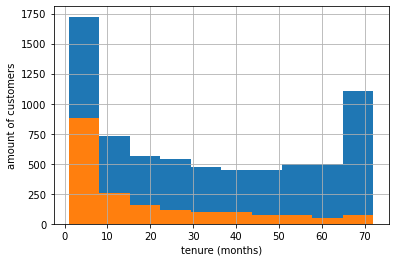

In [40]:
# comparison of tenure
df.tenure_in_months.hist()
churned_df.tenure_in_months.hist()
plt.xlabel('tenure (months)')
plt.ylabel('amount of customers')

In [41]:
# _, ax = plt.subplots(nrows=1, ncols=19, figsize=(16, 6))
# for i, column in enumerate(columns):
#     sns.barplot(column, 'churn', data=df, ax=ax[i], alpha=0.5)
#     plt.show()

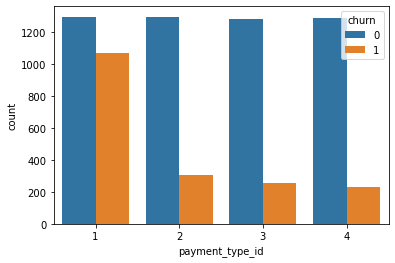

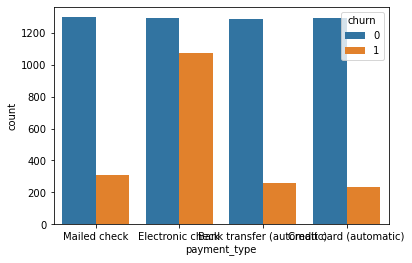

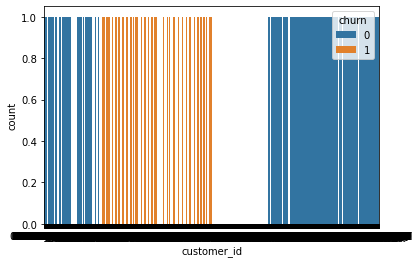

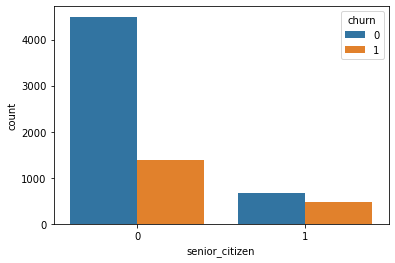

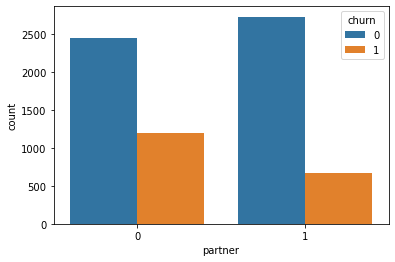

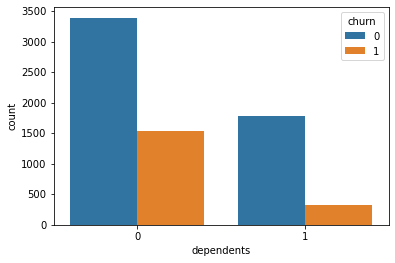

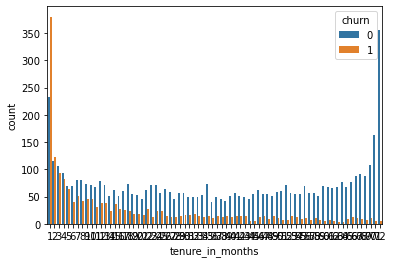

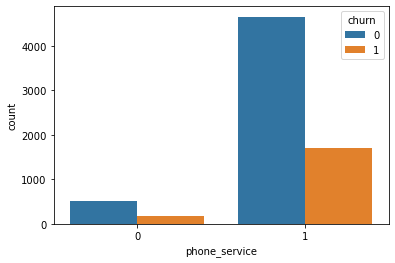

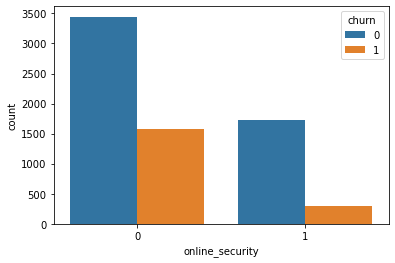

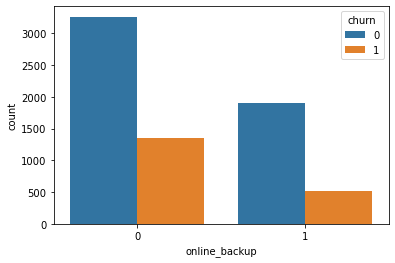

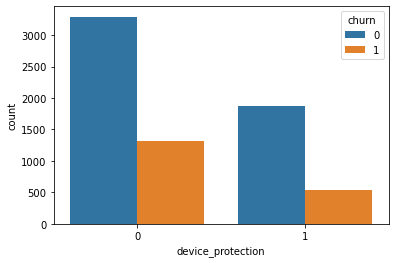

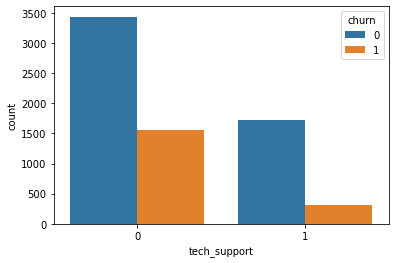

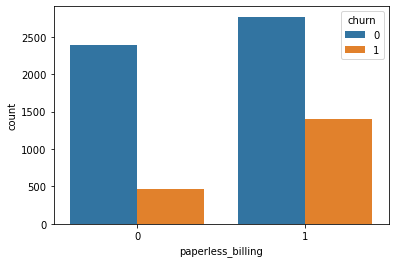

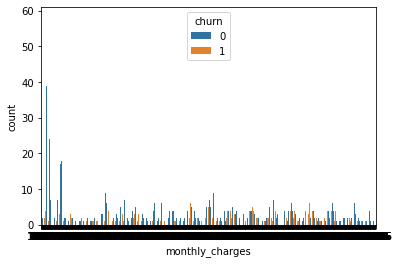

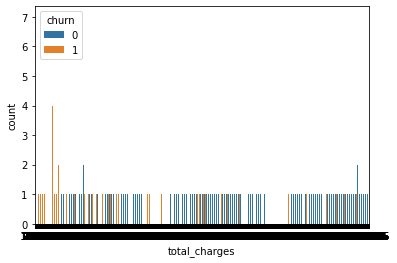

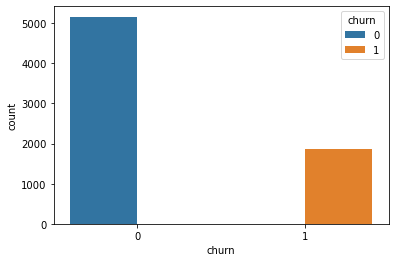

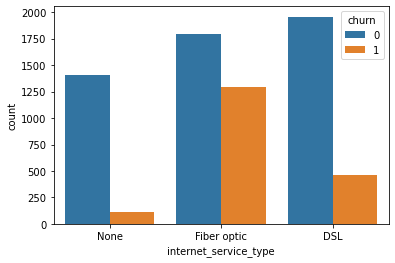

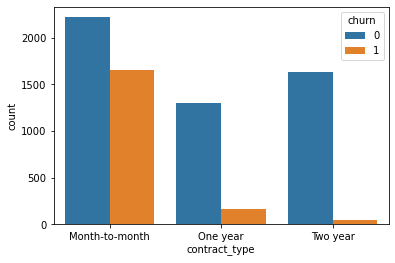

In [42]:
for i in df.columns:
    sns.countplot(data=df, x=i, hue='churn')
    plt.show()

<AxesSubplot:xlabel='churn', ylabel='count'>

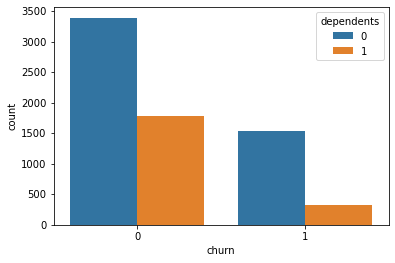

In [43]:
sns.countplot(x='churn', hue='dependents', data=df)

<AxesSubplot:xlabel='churn', ylabel='count'>

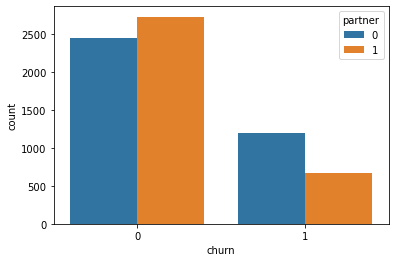

In [44]:
# partners don't play a part
sns.countplot(x='churn', hue='partner', data=df)

In [45]:
correl = df.corr()
correl.T

,payment_type_id,senior_citizen,partner,dependents,tenure_in_months,phone_service,online_security,online_backup,device_protection,tech_support,paperless_billing,monthly_charges,total_charges,churn
payment_type_id,1.000000,-0.093712,0.133280,0.124002,0.340939,-0.003106,0.162848,0.096246,0.110953,0.167189,-0.101790,-0.074640,0.222694,-0.262918
senior_citizen,-0.093712,1.000000,0.016957,-0.210550,0.015683,0.008392,-0.038576,0.066663,0.059514,-0.060577,0.156258,0.219874,0.102411,0.150541
partner,0.133280,0.016957,1.000000,0.452269,0.381912,0.018397,0.143346,0.141849,0.153556,0.120206,-0.013957,0.097825,0.319072,-0.149982
dependents,0.124002,-0.210550,0.452269,1.000000,0.163386,-0.001078,0.080786,0.023639,0.013900,0.063053,-0.110131,-0.112343,0.064653,-0.163128
tenure_in_months,0.340939,0.015683,0.381912,0.163386,1.000000,0.007877,0.328297,0.361138,0.361520,0.325288,0.004823,0.246862,0.825880,-0.354049
phone_service,-0.003106,0.008392,0.018397,-0.001078,0.007877,1.000000,-0.091676,-0.052133,-0.070076,-0.095138,0.016696,0.248033,0.113008,0.011691
online_security,0.162848,-0.038576,0.143346,0.080786,0.328297,-0.091676,1.000000,0.283285,0.274875,0.354458,-0.004051,0.296447,0.412619,-0.171270
online_backup,0.096246,0.066663,0.141849,0.023639,0.361138,-0.052133,0.283285,1.000000,0.303058,0.293705,0.127056,0.441529,0.510100,-0.082307
device_protection,0.110953,0.059514,0.153556,0.013900,0.361520,-0.070076,0.274875,0.303058,1.000000,0.332850,0.104079,0.482607,0.522881,-0.066193
tech_support,0.167189,-0.060577,0.120206,0.063053,0.325288,-0.095138,0.354458,0.293705,0.332850,1.000000,0.037536,0.338301,0.432868,-0.164716


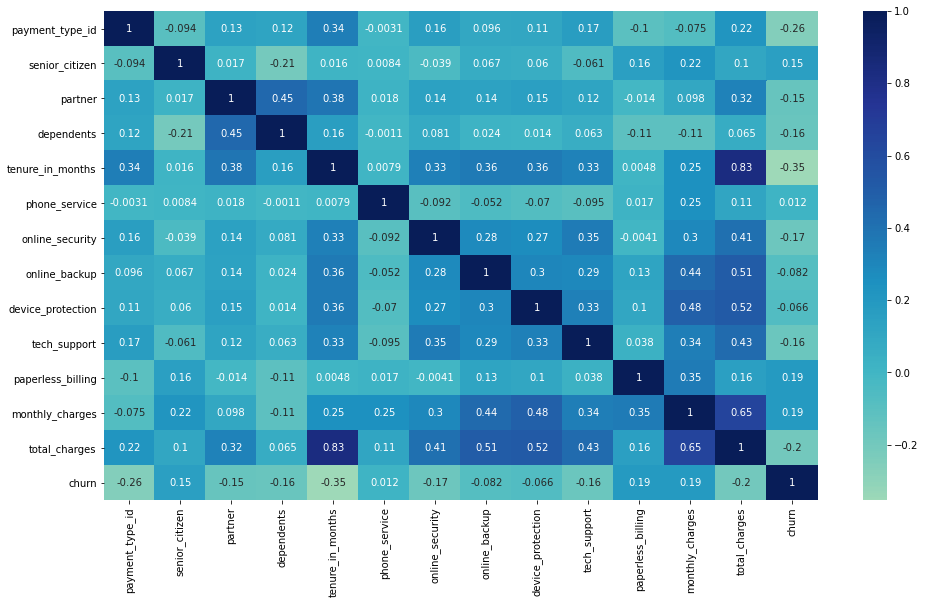

In [46]:
plt.figure(figsize=(16, 9))
sns.heatmap(((df.corr())), cmap='YlGnBu', center=0, annot=True)

plt.title('')
plt.show()

Text(0.5, 1.0, 'Feautures  Correlating with Churn')

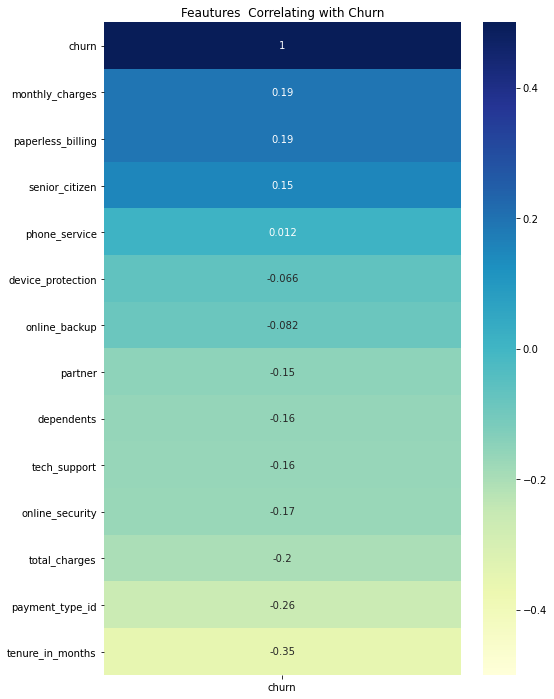

In [47]:
plt.figure(figsize=(8,12))
churn_heatmap = sns.heatmap(df.corr()[['churn']].sort_values(by='churn', ascending=False), cmap='YlGnBu', vmin=-.5, vmax=.5, annot=True)
churn_heatmap.set_title('Feautures  Correlating with Churn')

In [48]:
churned_df.sample().T

,2136
payment_type_id,1
payment_type,Electronic check
customer_id,7450-NWRTR
senior_citizen,1
partner,0
dependents,0
tenure_in_months,12
phone_service,1
online_security,0
online_backup,0


### Takeaways:
- Columns with obvious correlation:
 - payment_type
 - senior_citizen
 - contract_type
 - internet_service_type
 - dependents

Let's further explore other possible associations.

In [50]:
# oops we need to get our dummies now
# df = create_dummies(df)

In [51]:
# split my dad (should be done earlier for explore)
train, validate, test = prepare.telco_split(df)

In [52]:
train.shape, validate.shape, test.shape

((3937, 18), (1688, 18), (1407, 18))

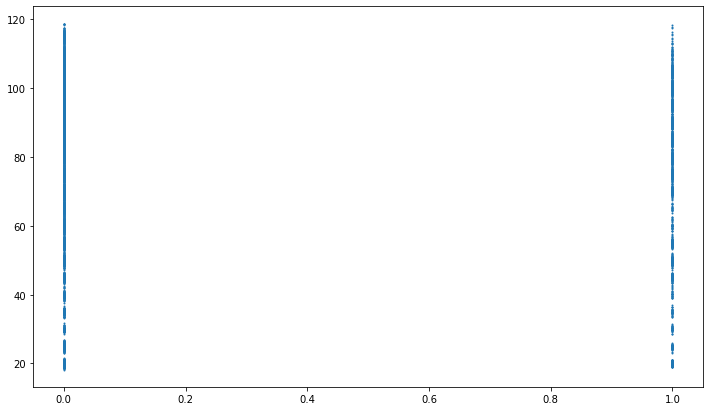

In [53]:
# this is a lovely graph that tells me nothing
plt.figure(figsize=(12,7))
x = df.churn
y = df.monthly_charges
plt.scatter(x, y, s=1)

Let's further analyze associations with paperless billing and partners.

${H_0}$ : There is no association with paperless billing and customer churn\
${H_a}$ : Paperless billing does have an association to churn

In [54]:
# we set our alpha up for statistical testing
alpha = 0.05

In [55]:
train.head().T

,5399,2876,659,5843,2229
payment_type_id,2,1,2,3,3
payment_type,Mailed check,Electronic check,Mailed check,Bank transfer (automatic),Bank transfer (automatic)
customer_id,0831-JNISG,1963-SVUCV,0611-DFXKO,7696-CFTAT,7916-VCCPB
senior_citizen,0,0,0,0,0
partner,1,0,1,1,1
dependents,1,0,0,1,1
tenure_in_months,71,1,20,37,16
phone_service,1,1,1,1,1
online_security,0,0,0,0,0
online_backup,0,0,0,0,1


In [56]:
observed = pd.crosstab(train.churn, train.paperless_billing)
observed

paperless_billing,0,1
churn,,
0,1382,1507
1,276,772


In [57]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [58]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[1382 1507]
 [ 276  772]]
---
Expected

[[1216 1672]
 [ 441  606]]
---

chi^2 = 144.9512
p     = 0.0000


In [59]:
if p < alpha:
    print('We reject the null hypothesis')
    print('We move forward with the alternate hypothesis. The two samples are associated')
else:
    print('We accept the alternate hypothesis')

We reject the null hypothesis
We move forward with the alternate hypothesis. The two samples are associated


## NEW

${H_0}$ : Having a partner is independent from customer churn\
${H_a}$ : Having a partner does have an association to churn

In [61]:
# another test on partners
observed = pd.crosstab(train.churn, train.partner)
observed

partner,0,1
churn,,
0,1376,1513
1,666,382


In [62]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [63]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:}')

Observed

[[1376 1513]
 [ 666  382]]
---
Expected

[[1498 1390]
 [ 543  504]]
---

chi^2 = 77.4423
p     = 1.3665799090892278e-18


In [64]:
if p < alpha:
    print('We reject the null hypothesis')
    print('We move forward with the alternate hypothesis. The two samples are associated')
else:
    print('We accept the alternate hypothesis')

We reject the null hypothesis
We move forward with the alternate hypothesis. The two samples are associated


------------------------------------------------------------------------------
${H_0}$: Mean of monthly charges of churned customers = Mean of monthly charges of all customers.\
${H_a}$: Mean of monthly charges of churnes customers > Mean of monthly charges of all customers.

<AxesSubplot:>

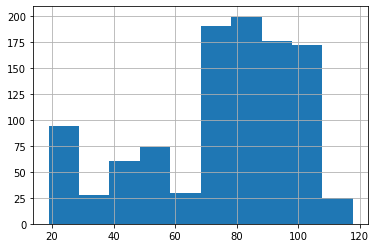

In [73]:
## maybe two a t test with 
## do some plots here then set up my test
train[train.churn==1].monthly_charges.hist()

<AxesSubplot:>

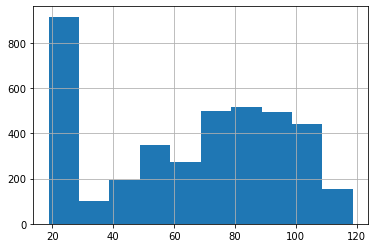

In [74]:
# overall charges
train.monthly_charges.hist()

<Figure size 1152x648 with 0 Axes>

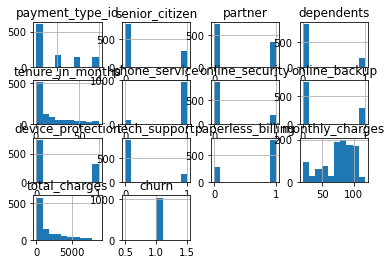

In [70]:
# an interesting mistake
plt.figure(figsize=(16,9))
train[train.churn== 1].hist()
plt.show()

In [71]:
train.sample(3).T

,4661,3987,6760
payment_type_id,2,3,4
payment_type,Mailed check,Bank transfer (automatic),Credit card (automatic)
customer_id,7716-YTYHG,3251-YMVWZ,5781-RFZRP
senior_citizen,0,0,0
partner,1,0,1
dependents,1,0,0
tenure_in_months,48,53,71
phone_service,1,1,1
online_security,0,0,1
online_backup,0,0,1


# MODELING

In [ ]:
# create dummies